# Using the `waterdata` module to pull data from the USGS Water Data APIs
The `waterdata` module replaces the `nwis` module for accessing USGS water data. It leverages the [Water Data APIs](https://api.waterdata.usgs.gov/) to download metadata, daily values, and instantaneous values. 

While the specifics of this transition timeline are opaque, it is advised to switch to the new functions as soon as possible to reduce unexpected interruptions in your workflow.

As always, please report any issues you encounter on our [Issues](https://github.com/DOI-USGS/dataretrieval-python/issues) page. If you have questions or need help, please reach out to us at comptools@usgs.gov.

## Prerequisite: Get your Water Data API key
We highly suggest signing up for your own API key [here](https://api.waterdata.usgs.gov/signup/) to afford yourself higher rate limits and more reliable access to the data. If you opt not to register for an API key, then the number of requests you can make to the Water Data APIs is considerably lower, and if you share an IP address across users or workflows, you may hit those limits even faster. Luckily, registering for an API key is free and easy.

Once you've copied your API key and saved it in a safe place, you can set it as an environment variable in your python script for the current session:

```python
import os
os.environ['API_USGS_PAT'] = 'your_api_key_here'
``` 
Note that the environment variable name is `API_USGS_PAT`, which stands for "API USGS Personal Access Token".

If you'd like a more permanent, repository-specific solution, you can use the `python-dotenv` package to read your API key from a `.env` file in your repository root directory, like this:

```python
!pip install python-dotenv # only run this line once to install the package in your environment
from dotenv import load_dotenv
load_dotenv()  # this will load the environment variables from the .env file
```
Make sure your `.env` file contains the following line:
```
API_USGS_PAT=your_api_key_here
```
Also, do not commit your `.env` file to version control, as it contains sensitive information. You can add it to your `.gitignore` file to prevent accidental commits.

## Lay of the Land
Now that your API key is configured, it's time to take a 10,000-ft view of the functions in the `waterdata` module.

### Metadata endpoints
These functions retrieve metadata tables that can be used to refine your data requests.

- `get_reference_table()` - Not sure which parameter code you're looking for, or which hydrologic unit your study area is in? This function will help you find the right input values for the data endpoints to retrieve the information you want.
- `get_codes()` - Similar to `get_reference_table()`, this function retrieves dataframes containing available input values that correspond to the Samples water quality database.

### Data endpoints
- `get_daily()` - Daily values for monitoring locations, parameters, stat codes, and more.
- `get_continuous()` - Instantaneous values for monitoring locations, parameters, statistical codes, and more.
- `get_monitoring_locations()`- Monitoring location information such as name, monitoring location ID, latitude, longitude, huc code, site types, and more.
- `get_time_series_metadata()` - Timeseries metadata across monitoring locations, parameter codes, statistical codes, and more. Can be used to answer the question: what types of data are collected at my site(s) of interest and over what time period are/were they collected? 
- `get_latest_continuous()` - Latest instantaneous values for requested monitoring locations, parameter codes, statistical codes, and more.
- `get_latest_daily()` - Latest daily values for requested monitoring locations, parameter codes, statistical codes, and more.
- `get_field_measurements()` - Physically measured values (a.k.a discrete) of gage height, discharge, groundwater levels, and more for requested monitoring locations.
- `get_samples()` - Discrete water quality sample results for monitoring locations, observed properties, and more.

### A few key tips
- You'll notice that each of the data functions have many unique inputs you can specify. **DO NOT** specify too many! Specify *just enough* inputs to return what you need. But do not provide redundant geographical or parameter information as this may slow down your query and lead to errors.
- Each function returns a Tuple, containing a dataframe and a Metadata class. If you have `geopandas` installed in your environment, the dataframe will be a `GeoDataFrame` with a geometry included. If you do not have `geopandas`, the dataframe will be a `pandas` dataframe with the geometry contained in a coordinates column. The Metadata object contains information about your query, like the query url.
- If you do not want to return the `geometry` column, use the input `skip_geometry=True`.
- All of these functions (except `get_samples()`) have a `limit` argument, which signifies the number of rows returned with each "page" of data. The Water Data APIs use paging to chunk up large responses and send data most efficiently to the requester. The `waterdata` functions collect the rows of data from each page and combine them into one final dataframe at the end. The default and maximum limit per page is 50,000 rows. In other words, if you request 100,000 rows of data from the database, it will return all the data in 2 pages, and each page counts as a "request" using your API key. If you were to change the argument to `limit=10000`, then each page returned would contain 10,000 rows, and it would take 10 requests/pages to return the total 100,000 rows. In general, there is no need to adjust the `limit` argument. However, if you are working with slow internet speeds, adjusting the `limit` argument may reduce chances of failures due to bandwidth.
- You can find some other helpful tips in the [Water Data API documentation](https://api.waterdata.usgs.gov/docs/ogcapi/).

## Examples
Let's get into some examples using the functions listed above. First, we need to load the `waterdata` module and a few other packages and functions to go through the examples. To run the entirety of this notebook, you will need to install `dataretrieval`, `matplotlib`, and `geopandas` packages. `matplotlib` is needed to create the plots, and `geopandas` is needed to create the interactive maps.

In [1]:
# Install necessary packages to run notebook
!pip install dataretrieval
!pip install matplotlib
!pip install geopandas

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from IPython.display import display
from datetime import datetime, timedelta
from datetime import date
from dateutil.relativedelta import relativedelta
from dataretrieval import waterdata

#### Reference tables

In [3]:
pcodes,metadata = waterdata.get_reference_table("parameter-codes")
display(pcodes.head())

Geopandas not installed. Geometries will be flattened into pandas DataFrames.


,parameter_code_id,parameter_name,unit_of_measure,parameter_group_code,parameter_description,medium,statistical_basis,time_basis,weight_basis,particle_size_basis,sample_fraction,temperature_basis,epa_equivalence
0,00001,"Xsec loc, US from rb",ft,INF,"Location in cross section, distance from right...",None,None,None,None,None,None,None,Agree
1,00002,"Xsec loc, US from rb",%,INF,"Location in cross section, distance from right...",None,None,None,None,None,None,None,Agree
2,00003,Sampling depth,ft,INF,"Sampling depth, feet",None,None,None,None,None,None,None,Agree
3,00004,Stream width,ft,PHY,"Stream width, feet",None,None,None,None,None,None,None,Agree
4,00005,"Loctn in X-sec,depth",%,INF,"Location in cross section, fraction of total d...",None,None,None,None,None,Total,None,Agree


Let's say we want to find all parameter codes relating to streamflow discharge. We can use some string matching to find applicable codes.

In [4]:
streamflow_pcodes = pcodes[pcodes['parameter_name'].str.contains('streamflow|discharge', case=False, na=False)]
display(streamflow_pcodes[['parameter_code_id', 'parameter_name']])

,parameter_code_id,parameter_name
42,00060,Discharge
43,00061,"Discharge, instant."
479,01351,"Streamflow, severity"
769,04122,"Bedload discharge, daily mean"
1701,30208,Discharge
1702,30209,Instantaneous Discharge
3704,50042,Discharge
8838,62856,"Discharge, storm event peak"
13745,70227,"Direction,StreamFlow"
13952,72122,"Discharge, storm event median"


Interesting that there are so many different streamflow-related parameter codes! Going on experience, let's use the most common one, `00060`, which is "Discharge, cubic feet per second".

### Timeseries metadata

Now that we know which parameter code we want to use, let's find all the stream monitoring locations that have recent discharge data and at least 10 years of daily values in the state of Nebraska. We will use the `waterdata.get_time_series_metadata()` function to suss out which sites fit the bill. This function will return a row for each *timeseries* that matches our inputs. It doesn't contain the daily discharge values themselves, just information *about* that timeseries.

First, let's get our expected date range in order. Note that the `waterdata` functions are capable of taking in bounded and unbounded date and datetime ranges. In this case, we want the start date of the discharge timeseries to be no more recent than 10 years ago, and we want the end date of the timeseries to be from at most a week ago. We can use the notation `{date}/..` to mean that we want all timeseries that end a week ago or more recently. Similarly, we can use the notation `../{date}` to mean we want all timeseries that started at least 10 years ago (and thus likely have at least 10 years of data).

In [5]:
ten_years_ago =(date.today() - relativedelta(years=10)).strftime("%Y-%m-%d")
one_week_ago = (datetime.now() - timedelta(days=7)).date().strftime("%Y-%m-%d")

We will also use the `skip_geometry` argument in our timeseries metadata call. By default, most `waterdata` functions return a geometry column containing the monitoring location's coordinates. This is a really cool feature that we will use later, but for this particular data pull, we don't need it. Setting `skip_geometry=True` makes the returned dataframe smaller and more efficient.

In [6]:
NE_discharge,_ = waterdata.get_time_series_metadata(
    state_name="Nebraska",
    parameter_code='00060',
    begin=f"../{ten_years_ago}",
    end=f"{one_week_ago}/..",
    skip_geometry=True
)

In [7]:
display(NE_discharge.sort_values("monitoring_location_id").head())
print(f"There are {len(NE_discharge['monitoring_location_id'].unique())} sites with recent discharge data available in the state of Nebraska")

,time_series_id,unit_of_measure,parameter_name,parameter_code,statistic_id,hydrologic_unit_code,state_name,last_modified,begin,end,...,end_utc,computation_period_identifier,computation_identifier,thresholds,sublocation_identifier,primary,monitoring_location_id,web_description,parameter_description,parent_time_series_id
28,2daeaac402fb46e594ad265d1fed145c,ft^3/s,Discharge,00060,00003,101701040305,Nebraska,2026-01-20 13:55:58.275629,1957-10-01 00:00:00.000001,2026-01-19 00:00:00.000001,...,2026-01-19 06:00:00+00:00,Daily,Mean,[],None,Primary,USGS-06453600,None,"Discharge, cubic feet per second",c8f66a81be244941a4c8975ac4393f57
162,c8f66a81be244941a4c8975ac4393f57,ft^3/s,Discharge,00060,00011,101701040305,Nebraska,2026-01-20 06:30:35.849042,1990-10-01 05:30:00.000001,2026-01-20 06:15:00.000001,...,2026-01-20 12:15:00+00:00,Points,Instantaneous,[{'Name': 'Peak of record discharge on March 2...,None,Primary,USGS-06453600,Discharge from Primary Sensor,"Discharge, cubic feet per second",None
126,9d41bfe5d9374b998cb9c93310bbbdd8,ft^3/s,Discharge,00060,00011,101500040905,Nebraska,2026-01-20 09:58:48.427069,1991-05-17 05:00:00.000001,2026-01-20 09:45:00.000001,...,2026-01-20 15:45:00+00:00,Points,Instantaneous,"[{'Name': 'VERY HIGH', 'Type': 'ThresholdAbove...",None,Primary,USGS-06461500,None,"Discharge, cubic feet per second",None
133,a661caa558244bf8a054018ccae0553a,ft^3/s,Discharge,00060,00003,101500040905,Nebraska,2026-01-20 06:58:48.177794,1945-10-01 00:00:00.000001,2026-01-19 00:00:00.000001,...,2026-01-19 06:00:00+00:00,Daily,Mean,[],None,Primary,USGS-06461500,None,"Discharge, cubic feet per second",9d41bfe5d9374b998cb9c93310bbbdd8
202,f5f7a38d1ad548dbb6f4cb876f9833a5,ft^3/s,Discharge,00060,00011,101500041309,Nebraska,2026-01-20 09:50:32.314326,1990-10-01 05:30:00.000001,2026-01-20 09:45:00.000001,...,2026-01-20 15:45:00+00:00,Points,Instantaneous,"[{'Name': 'VERY LOW', 'Type': 'ThresholdBelow'...",None,Primary,USGS-06463500,None,"Discharge, cubic feet per second",None


There are 102 sites with recent discharge data available in the state of Nebraska


In the dataframe above, we are looking at 5 timeseries returned, ordered by monitoring location. You can also see that the first two rows show two different kinds of discharge for the same monitoring location: a mean daily discharge timeseries (with [statistic id](https://api.waterdata.usgs.gov/docs/ogcapi/) 00003, which represents "mean") and an instantaneous discharge timeseries (with statistic id 00011, which represents "points" or "instantaneous" values). Look closely and you may also notice that the `parent_timeseries_id` column for daily mean discharge matches the `time_series_id` for the instantaneous discharge. This is because once instantaneous measurements began at the site, they were used to calculate the daily mean.

### Monitoring locations
Now that we know which sites have recent discharge data, let's find stream sites and plot them on a map. We will use the `waterdata.get_monitoring_locations()` function to grab more metadata about these sites.

We can feed the unique monitoring location IDs from `NE_discharge` into the `get_monitoring_locations()` function to get the metadata for just those sites. However, there is a limit to the number of IDs that can be passed in one call to the API. Further down in this notebook, you'll see an example where we successfully feed all ~100 IDs in one call to the API. However, for demonstration purposes, we will split the list of monitoring location IDs into a few chunks of 50 sent to the API and stitch the resulting dataframes together. A loose rule of thumb is to keep the number of IDs below 200, but this exact number will depend on the typical length of each monitoring location ID (i.e. if your monitoring location IDs are > 13 characters long: "USGS-XXXXXXXX"+, you will need to feed in less than 200 at a time).

In [8]:
chunk_size=50
site_list = NE_discharge['monitoring_location_id'].unique().tolist()
chunks = [site_list[i:i + chunk_size] for i in range(0, len(site_list), chunk_size)]
NE_locations = pd.DataFrame()
for site_group in chunks:
        try:
            chunk_data,_ = waterdata.get_monitoring_locations(
                monitoring_location_id=site_group,
                site_type_code="ST"
            )
            if not chunk_data.empty:
                NE_locations = pd.concat([NE_locations, chunk_data])
        except Exception as e:
            print(f"Chunk failed: {e}")

display(NE_locations[["monitoring_location_id", "monitoring_location_name", "hydrologic_unit_code"]].head())

,monitoring_location_id,monitoring_location_name,hydrologic_unit_code
0,USGS-06453600,"Ponca Creek at Verdel, Nebr.",101701040305
1,USGS-06463720,"Niobrara River at Mariaville, Nebr.",101500041506
2,USGS-06600900,"South Omaha Creek at Walthill, Nebr.",102300010103
3,USGS-06610770,"Big Papillion Creek at Q Street at Omaha, Nebr.",102300060205
4,USGS-06610795,"Papillion Creek at Fort Crook, Nebr.",102300060206


That took a little bit of work to loop through the site chunks and bind the data back together. Admittedly, there may be times where chunking and iterating might be the most efficient workflow. But in this particular case, we have a less onerous option available: `get_monitoring_locations()` has a `state_name` argument. It will likely be faster to pull all stream sites for Nebraska and then filter down to the sites present in the timeseries dataframe: no iteration needed. Let's try this too.

In [9]:
NE_locations,_ = waterdata.get_monitoring_locations(
    state_name="Nebraska",
    site_type_code="ST"
    )

NE_locations_discharge = NE_locations.loc[NE_locations['monitoring_location_id'].isin(NE_discharge['monitoring_location_id'].unique().tolist())]
display(NE_locations_discharge[["monitoring_location_id", "monitoring_location_name", "hydrologic_unit_code"]].head())

,monitoring_location_id,monitoring_location_name,hydrologic_unit_code
14,USGS-06453600,"Ponca Creek at Verdel, Nebr.",101701040305
44,USGS-06461500,"Niobrara River near Sparks, Nebr.",101500040905
61,USGS-06463500,"Long Pine Creek near Riverview, Nebr.",101500041309
63,USGS-06463720,"Niobrara River at Mariaville, Nebr.",101500041506
79,USGS-06465500,"Niobrara River near Verdel, Nebr.",101500071004


If you have `geopandas` installed, the function will return a `GeoDataFrame` with a `geometry` column containing the monitoring locations' coordinates. You can use `gpd.explore()` to view your geometry coordinates on an interactive map. We will demo this functionality below (Hover over the site points to see all the columns returned from `waterdata.get_monitoring_locations()`). If you don't have `geopandas` installed, `dataretrieval` will return a regular `pandas` DataFrame with coordinate columns instead.

In [10]:
NE_locations_discharge.set_crs(crs="WGS84").explore()

ImportError: The 'folium>=0.12', 'matplotlib' and 'mapclassify' packages are required for 'explore()'. You can install them using 'conda install -c conda-forge "folium>=0.12" matplotlib mapclassify' or 'pip install "folium>=0.12" matplotlib mapclassify'.

### Latest daily and instantaneous values
Now that we know which sites in Nebraska have recent discharge data, and we know where they are located, we can start downloading some actual flow values. Let's start with some of the most "lightweight" functions, `waterdata.get_latest_daily()` and `waterdata.get_latest_continuous()`, which will return only the latest value for each monitoring location requested. 

Recall from above, we are working with ~100 sites with discharge data. Conveniently, the `waterdata` functions are *usually* pretty good at handling requests of up to ~200 monitoring locations. However, if you have more than 200, you may be better off chopping up your list of sites into a few lists that you loop over. 

In [11]:
latest_dv,_ = waterdata.get_latest_daily(
    monitoring_location_id=NE_locations_discharge['monitoring_location_id'].tolist(),
    parameter_code="00060",
    statistic_id="00003"
)
display(latest_dv.head())

,geometry,time_series_id,monitoring_location_id,parameter_code,statistic_id,time,value,unit_of_measure,approval_status,qualifier,last_modified,latest_daily_id
0,POINT (-96.59513 40.85717),25d572ff16a347438fe186769cbe4cde,USGS-06803520,00060,00003,2026-01-14,0.18,ft^3/s,Provisional,None,2026-01-16 14:44:14.656890+00:00,86629764-e9b9-40b8-9238-51dbd3a3ea17
1,POINT (-96.96086 40.59658),842bef886d234a7cb938653ce45e95e9,USGS-06881000,00060,00003,2026-01-16,112.00,ft^3/s,Provisional,None,2026-01-20 14:32:21.866365+00:00,1c79e4b5-f7b0-4a76-8001-e1940fbd0a39
2,POINT (-96.04283 41.15599),986fee425cde4663bcd93b2cf4c952bf,USGS-06610793,00060,00003,2026-01-17,NaN,ft^3/s,Provisional,[SEASONAL],2026-01-18 08:16:24.878111+00:00,13531589-12d2-40aa-b95b-4db862e34b5e
3,POINT (-96.48793 42.32141),af8d503229314a349970e47209c27480,USGS-06601000,00060,00003,2026-01-18,NaN,ft^3/s,Provisional,[ICE],2026-01-19 08:17:58.835730+00:00,28a8c3a5-50eb-4370-a956-ed8dde8ec32e
4,POINT (-98.1754 42.81086),2daeaac402fb46e594ad265d1fed145c,USGS-06453600,00060,00003,2026-01-19,NaN,ft^3/s,Provisional,[ICE],2026-01-20 08:08:07.867606+00:00,33075b64-7adc-46d3-8f0d-a9b2045ec89a


Note that because these measurements are less than a week old, most of them are still tagged as "Provisional" in the `approval_status` column. Some may also be missing values in the `value` column. You can often check the `qualifier` column for clues as to why a value is missing, or additional information specific to that measurement. Let's map out the monitoring locations again and color the points based on the latest daily value.

In [12]:
latest_dv['date'] = latest_dv['time'].astype(str)
latest_dv[['geometry', 'monitoring_location_id', 'date', 'value', 'unit_of_measure']].set_crs(crs="WGS84").explore(column='value', tiles='CartoDB dark matter', cmap='YlOrRd', scheme=None, legend=True)

ImportError: The 'folium>=0.12', 'matplotlib' and 'mapclassify' packages are required for 'explore()'. You can install them using 'conda install -c conda-forge "folium>=0.12" matplotlib mapclassify' or 'pip install "folium>=0.12" matplotlib mapclassify'.

Let's do the same routine with `waterdata.get_latest_continuous()`, but note that we do not need to specify the `statistic_id`: all instantaneous values have the statistical code "00011".

In [13]:
latest_instantaneous,_ = waterdata.get_latest_continuous(
    monitoring_location_id=NE_locations_discharge['monitoring_location_id'].tolist(),
    parameter_code="00060"
)

latest_instantaneous['datetime'] = latest_instantaneous['time'].astype(str)
latest_instantaneous[['geometry', 'monitoring_location_id', 'datetime', 'value', 'unit_of_measure']].set_crs(crs="WGS84").explore(column='value', cmap='YlOrRd', scheme=None, legend=True)

ImportError: The 'folium>=0.12', 'matplotlib' and 'mapclassify' packages are required for 'explore()'. You can install them using 'conda install -c conda-forge "folium>=0.12" matplotlib mapclassify' or 'pip install "folium>=0.12" matplotlib mapclassify'.

### Daily and continuous values datasets
While the "latest" functions might be helpful for "realtime" or "current" dashboards or reports, many users desire to work with a complete timeseries of daily summary (min, max, mean) or instantaneous values for their analyses. For these workflows, `waterdata.get_daily()` and `waterdata.get_continuous()` are helpful.

Using our current example, let's say that you want to compare daily and instantaneous discharge values for monitoring locations along the Missouri River in Nebraska.

In [14]:
missouri_river_sites = NE_locations_discharge.loc[NE_locations_discharge['monitoring_location_name'].str.contains("Missouri")]
display(missouri_river_sites[[
    'county_name',
    'site_type',
    'monitoring_location_id',
    'monitoring_location_name',
    'drainage_area',
    'altitude'
    ]])

,county_name,site_type,monitoring_location_id,monitoring_location_name,drainage_area,altitude
111,Dakota County,Stream,USGS-06486000,"Missouri River at Sioux City, IA",314600.0,1057.42
136,Douglas County,Stream,USGS-06610000,"Missouri River at Omaha, NE",322800.0,948.97
675,Otoe County,Stream,USGS-06807000,"Missouri River at Nebraska City, NE",410000.0,905.61
687,Richardson County,Stream,USGS-06813500,"Missouri River at Rulo, NE",414900.0,838.16


Currently, users may only request 3 years or less of continuous data in one pull. For this example, let's pull the last 1 year of daily mean values and instantaneous values for these Missouri River sites. We'll skip pulling geometry in the `waterdata.get_daily()` function; the `waterdata.get_continuous()` function does not return geometry at all to economize the size of the dataset returned.

In [15]:
one_year_ago = (date.today() - relativedelta(years=1)).strftime("%Y-%m-%d")
missouri_site_ids = missouri_river_sites['monitoring_location_id'].tolist()
missouri_site_names = missouri_river_sites['monitoring_location_name'].tolist()

In [16]:
daily_values,_ = waterdata.get_daily(
    monitoring_location_id=missouri_site_ids,
    parameter_code="00060",
    statistic_id="00003", # mean daily value
    time=f"{one_year_ago}/..",
    skip_geometry=True
)

In [17]:
instantaneous_values,_ = waterdata.get_continuous(
    monitoring_location_id=missouri_site_ids,
    parameter_code="00060",
    time=f"{one_year_ago}T00:00:00Z/.."
)

With these two datasets, let's plot daily and instantaneous discharge values for the four Missouri River sites using `matplotlib`. We will plot each site on a different subplot, with instantaneous values represented by a blue line and daily mean values represented by black points.

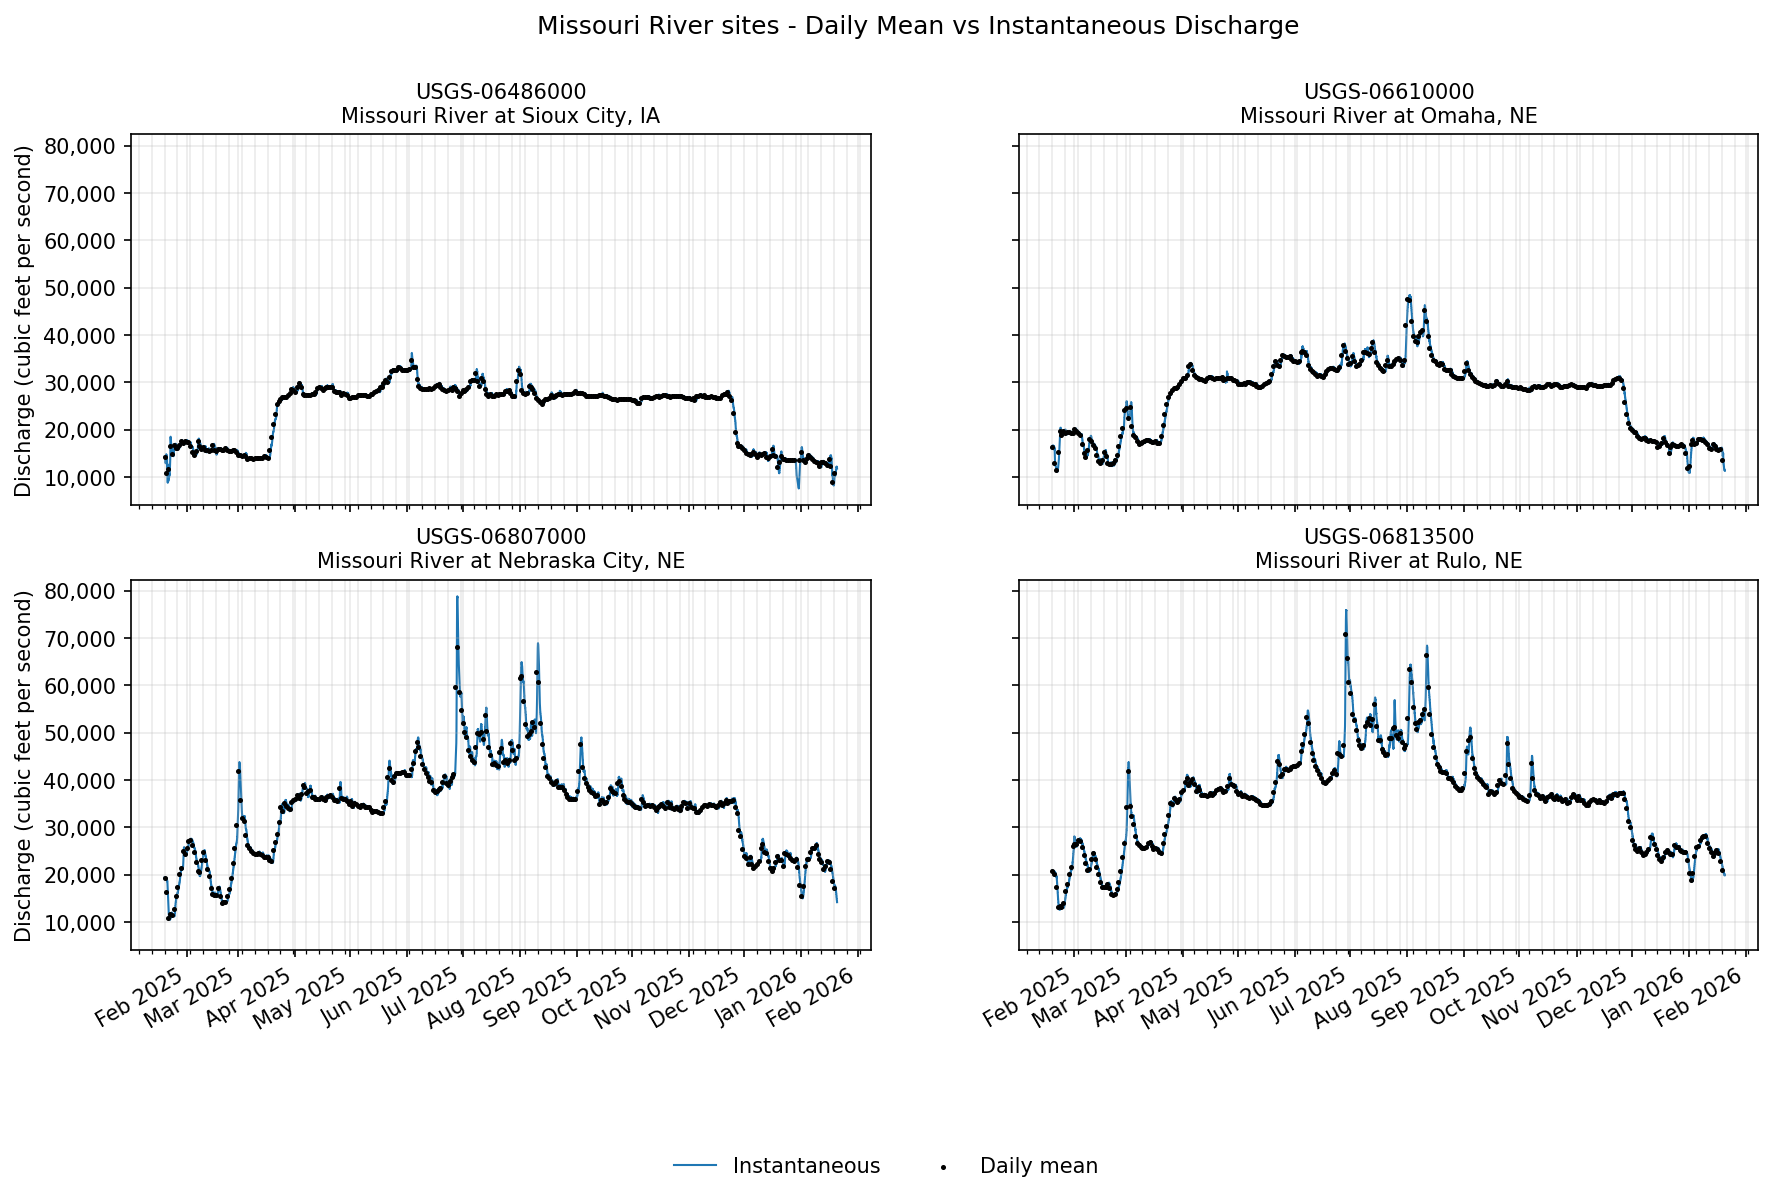

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8), dpi=150, sharex=False, sharey=True)
axes = axes.ravel()

# Y-axis formatter (with thousands separators)
tick_fmt = mtick.StrMethodFormatter('{x:,.0f}')

for ax, site, site_name in zip(axes, missouri_site_ids, missouri_site_names):
    # Filter per site & sort by time
    inst = instantaneous_values.loc[instantaneous_values['monitoring_location_id'] == site, ["time", "value"]].sort_values("time")
    daily = daily_values.loc[daily_values['monitoring_location_id'] == site, ["time", "value"]].sort_values("time")

    # Instantaneous (line)
    ax.plot(
        inst["time"], inst["value"],
        color="#1f77b4", lw=1.0, label="Instantaneous", zorder=1
    )

    # Daily mean (black dots)
    ax.scatter(
        daily["time"], daily["value"],
        c="black", s=2, label="Daily mean", zorder=2
    )

    # Axes styling
    ax.set_title(f"{site}\n{site_name}", fontsize=10)
    ax.grid(True, which="both", alpha=0.25)
    ax.yaxis.set_major_formatter(tick_fmt)

    # Time ticks
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO))

# Common axis labels (left y on both left subplots; x labels on bottom row)
axes[0].set_ylabel("Discharge (cubic feet per second)")
axes[2].set_ylabel("Discharge (cubic feet per second)")
axes[2].set_xlabel("")
axes[3].set_xlabel("")

handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2, frameon=False)
fig.suptitle(f"Missouri River sites - Daily Mean vs Instantaneous Discharge")
fig.autofmt_xdate()


### Field values
Finally, let's see if there are any discharge field measurements for these sites. These are manually recorded measurements (by a human), often used during calibration checks. We will use `waterdata.get_field_measurements()` to check. More commonly, a user would head to this function to gather groundwater level data, which are categorized as field measurements.

In [19]:
field_measurements,_ = waterdata.get_field_measurements(
    monitoring_location_id=missouri_site_ids,
    parameter_code="00060",
    time=f"{one_year_ago}T00:00:00Z/.."
)
display(field_measurements.head())

,geometry,field_visit_id,parameter_code,monitoring_location_id,observing_procedure_code,observing_procedure,value,unit_of_measure,time,qualifier,vertical_datum,approval_status,measuring_agency,last_modified,field_measurement_id
0,POINT (-95.42175 40.05206),0c25bcf0-f8f9-4044-b051-bb73bd19498c,00060,USGS-06813500,Z,Acoustic Doppler Current Profiler,18000,ft^3/s,2025-01-28 19:19:42+00:00,None,None,Approved,USGS,2025-06-13 18:55:43.542508+00:00,844b8fa8-de6e-4d42-aed2-be587511305b
1,POINT (-95.84708 40.68181),8d9e937b-7e60-4106-9b3d-dcc32c7323b1,00060,USGS-06807000,Z,Acoustic Doppler Current Profiler,21100,ft^3/s,2025-01-29 16:37:11+00:00,None,None,Approved,USGS,2025-06-17 19:41:06.711794+00:00,8d21a28b-e818-4cff-a6cc-9448f298eb7a
2,POINT (-96.41308 42.48619),9c2d9eb3-de9d-44d8-aca7-aa46de633040,00060,USGS-06486000,Z,Acoustic Doppler Current Profiler,16900,ft^3/s,2025-01-30 17:17:12+00:00,None,None,Approved,USGS,2025-06-16 20:30:51.750716+00:00,4f8ffeda-3d65-4219-9f65-6759beb27f82
3,POINT (-95.92325 41.25906),df9e30ec-5f70-431c-97f3-fc0ebd31044f,00060,USGS-06610000,Z,Acoustic Doppler Current Profiler,19100,ft^3/s,2025-01-31 16:48:25+00:00,None,None,Approved,USGS,2025-06-17 19:35:53.102935+00:00,dc9a2b8b-932c-4053-b858-c1f22d4ccaa7
4,POINT (-96.41308 42.48619),e9a04cf4-54fd-45f2-b742-d526250cae66,00060,USGS-06486000,Z,Acoustic Doppler Current Profiler,16300,ft^3/s,2025-02-03 17:10:55+00:00,None,None,Approved,USGS,2025-06-16 20:30:51.750716+00:00,06d4b3c4-ca1e-4c1b-bf73-a80c91a420f1


Hey! We have some! Let's add these to our plots from above. We'll loop through each monitoring location plot and add in field measurements as red points.

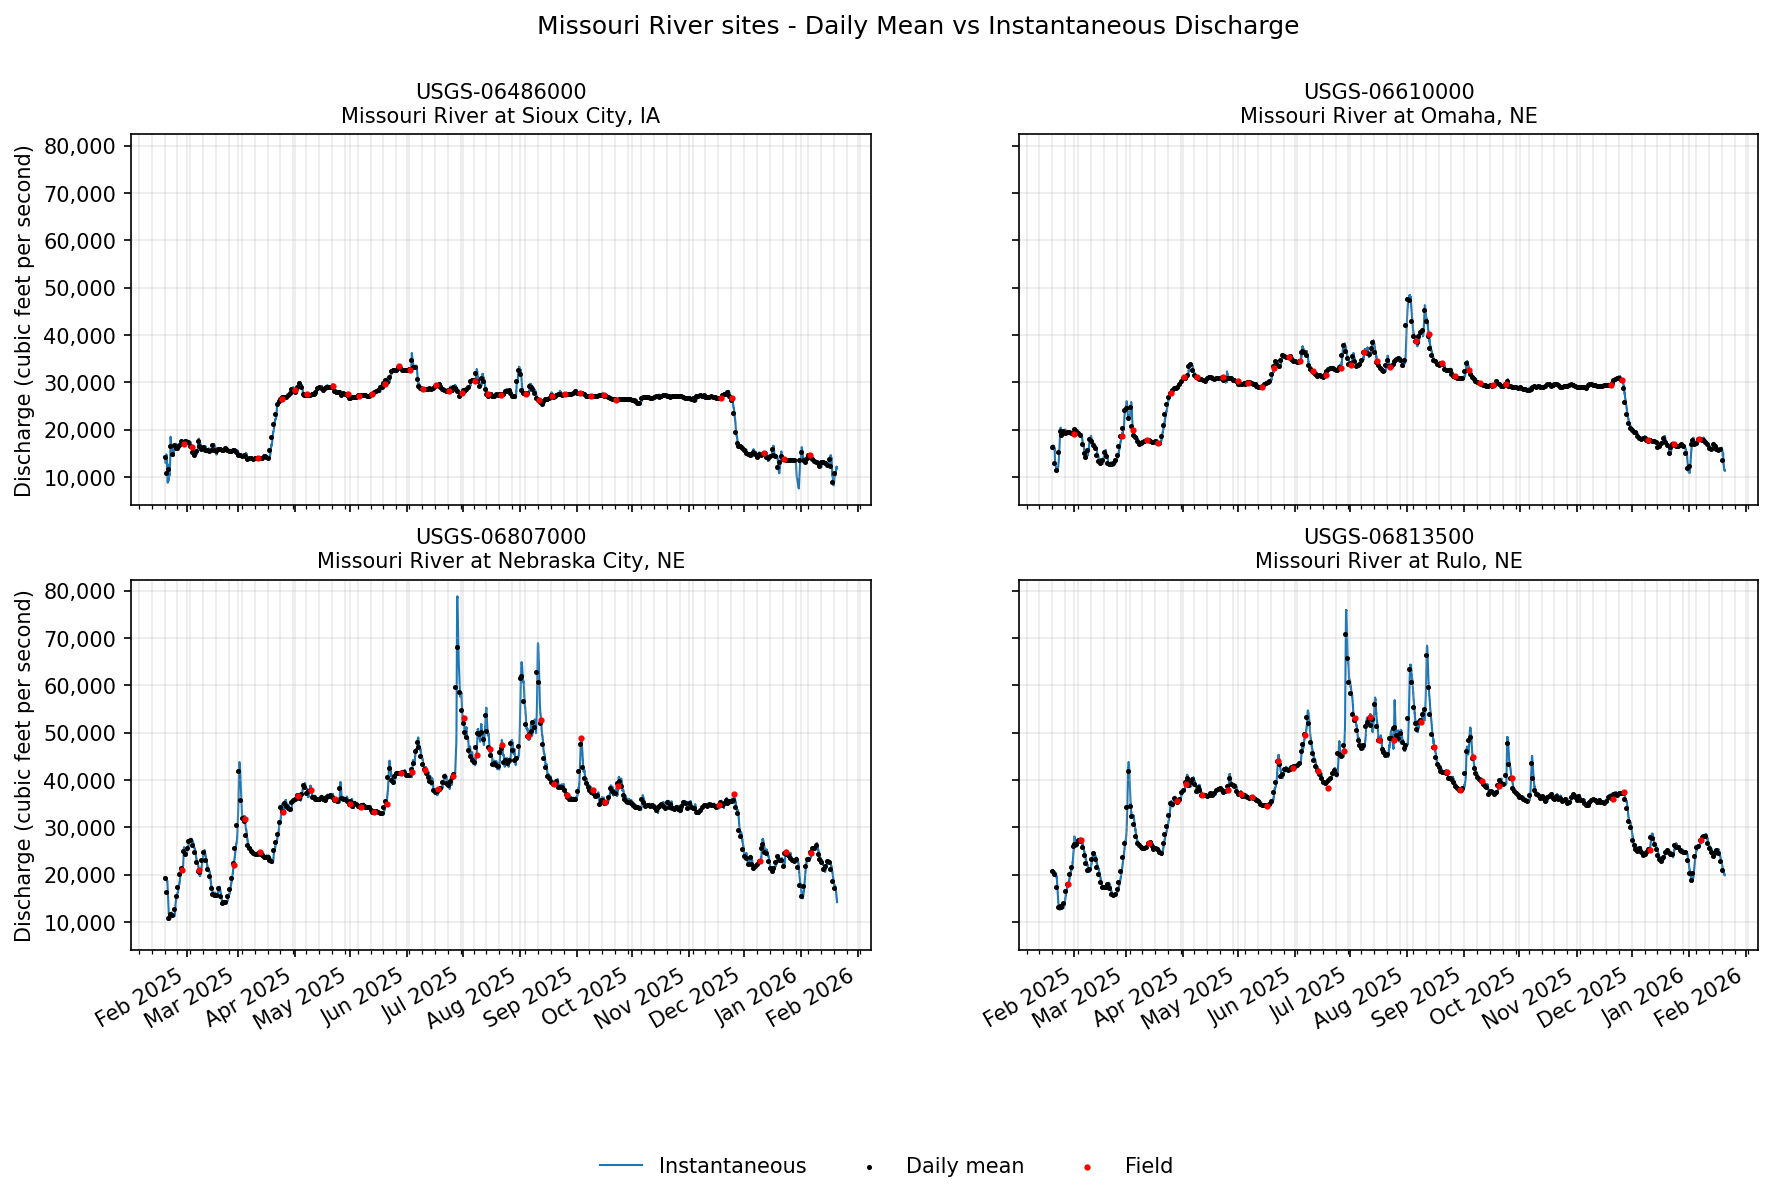

In [20]:
for ax, site in zip(axes, missouri_site_ids):
    field = field_measurements.loc[
        field_measurements['monitoring_location_id'] == site, ["time", "value"]
    ].sort_values("time")

    ax.scatter(
        field["time"], field["value"],
        c="red", s=4, label="Field", zorder=3
    )

# Remove any existing figure-level legends
for leg in fig.legends:
    leg.remove()
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False)

# Redraw the figure
fig.canvas.draw_idle()
fig


## Additional Resources
The USGS Water Data APIs belong to the Water Data for the Nation (WDFN) group of applications and tools. These products exist under the broader National Water Information System (NWIS) program. Check out the links below for more information on the USGS Water Data APIs and other ways to download or view USGS water data:
* [Water Data APIs Home](https://api.waterdata.usgs.gov/)
* [Get an API Key](https://api.waterdata.usgs.gov/signup/)
* [Water Data API OGC Endpoint Catalog](https://api.waterdata.usgs.gov/ogcapi/v0/collections?f=html)
* [Water Data Download Form](https://api.waterdata.usgs.gov/download)
* [Water Data for the Nation Home](https://waterdata.usgs.gov/)
* [Water Data for the Nation Feedback Form](https://waterdata.usgs.gov/questions-comments/?referrerUrl=https://api.waterdata.usgs.gov)
* [R dataRetrieval package](https://github.com/DOI-USGS/dataretrieval)
* [WDFN Blog Post on NWISWeb Decommissioning Timeline](https://waterdata.usgs.gov/blog/nwisweb-decommission-campaign2/)
